# Modeling and Evaluation

In [30]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [31]:
from pandas import read_csv

watch_df = read_csv("watch_df.csv")

In [32]:
# concatnate title + text into title_text
# X = df['title_text]
# y = df['subreddit']
# train test split X y
# vectorize X (both X_train X_test) -> fit_transform(X_train), transform(X_test)
# train and evaluate (both X_train X_test and also y_train y_test)
watch_df

,title,text,subreddit
0,Garmin dc40 troubles,"Hi, i have 2 garmin dc40 collars that have a b...",garmin
1,Checking to verify this combination will fit m...,"Hi all,I was pointed to Garmin devices by anot...",garmin
2,Garmin fenix 3,We need to do something this latest update 5.1...,garmin
3,Fenix 3 user manual,Anyone know where to find the user manual for ...,garmin
4,Fenix 3 Mistake,"I love my Fenix 3, but forgot to charge it las...",garmin
...,...,...,...
3558,The difference an adapter makes!!!,Switched to a pin adapter from the other adapt...,applewatch
3559,What is your favorite feature about Apple Watch?,I'm looking for apps to use with mine and want...,applewatch
3560,Anyone want a 42mm SGS+WSB+ML?,I could sell the watch and black band for 350....,applewatch
3561,How to find friends with Apple Watches?,Is there any way to scan your contacts and dis...,applewatch


In [33]:
# concatnate title + text into title_text
watch_df['title_text'] = watch_df['title'] + ' ' + watch_df['text']
watch_df.head()

,title,text,subreddit,title_text
0,Garmin dc40 troubles,"Hi, i have 2 garmin dc40 collars that have a b...",garmin,"Garmin dc40 troubles Hi, i have 2 garmin dc40 ..."
1,Checking to verify this combination will fit m...,"Hi all,I was pointed to Garmin devices by anot...",garmin,Checking to verify this combination will fit m...
2,Garmin fenix 3,We need to do something this latest update 5.1...,garmin,Garmin fenix 3 We need to do something this la...
3,Fenix 3 user manual,Anyone know where to find the user manual for ...,garmin,Fenix 3 user manual Anyone know where to find ...
4,Fenix 3 Mistake,"I love my Fenix 3, but forgot to charge it las...",garmin,"Fenix 3 Mistake I love my Fenix 3, but forgot ..."


In [34]:
# drop "title" and "text" columns
watch_df.drop(columns=['title', 'text'], inplace=True)
watch_df.head()

,subreddit,title_text
0,garmin,"Garmin dc40 troubles Hi, i have 2 garmin dc40 ..."
1,garmin,Checking to verify this combination will fit m...
2,garmin,Garmin fenix 3 We need to do something this la...
3,garmin,Fenix 3 user manual Anyone know where to find ...
4,garmin,"Fenix 3 Mistake I love my Fenix 3, but forgot ..."


## Modeling

In [35]:
X = watch_df[['title_text']]
y = watch_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [36]:
def vectorize_text(X_train, X_test, vectorizer):
    # remove "garmin" and "apple" from X
    X_train = X_train.str.replace('garmin', '').str.replace('apple', '')
    X_test = X_test.str.replace('garmin','').str.replace('apple', '')

    # fit and transform X
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # convert X to a DataFrame
    X_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
    return (X_train, X_test)

In [37]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, params):
    gs = GridSearchCV(model, params, cv=5)
    gs.fit(X_train, y_train)
    print(f"Best params: {gs.best_params_}")
    print(f"Best score: {gs.best_score_}")
    print(f"Train score: {gs.score(X_train, y_train)}")
    print(f"Test score: {gs.score(X_test, y_test)}")
    return gs

### Naive Bayes Models

In [39]:
cvec = CountVectorizer(stop_words='english')
X_train_cvec, X_test_cvec = vectorize_text(X_train["title_text"], X_test["title_text"], cvec)
nb = MultinomialNB()
nb_params = {
    'alpha': [0.1, 0.5, 1.0]
}
nb_gs = train_and_evaluate_model(X_train_cvec, X_test_cvec, y_train, y_test, nb, nb_params)

Best params: {'alpha': 0.1}
Best score: 0.9539745878399664
Train score: 0.9869011976047904
Test score: 0.9494949494949495


In [40]:
tvec = TfidfVectorizer(stop_words='english')
X_train_tvec, X_test_tvec = vectorize_text(X_train['title_text'], X_test['title_text'], tvec)
nb = MultinomialNB()
nb_params = {
    'alpha': [0.1, 0.5, 1.0]
}
nb_gs = train_and_evaluate_model(X_train_tvec, X_test_tvec, y_train, y_test, nb, nb_params)

Best params: {'alpha': 0.1}
Best score: 0.9247786061815255
Train score: 0.9790419161676647
Test score: 0.9337822671156004


### Random Forest

In [41]:
# Fit model with RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 1, 2, 3]
}
rf_gs = train_and_evaluate_model(X_train_cvec, X_test_cvec, y_train, y_test, rf, rf_params)

Best params: {'max_depth': None, 'n_estimators': 100}
Best score: 0.9595792642374601
Train score: 1.0
Test score: 0.9595959595959596


In [42]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 1, 2, 3]
}
rf_gs = train_and_evaluate_model(X_train_tvec, X_test_tvec, y_train, y_test, rf, rf_params)

Best params: {'max_depth': None, 'n_estimators': 200}
Best score: 0.9558381462424306
Train score: 1.0
Test score: 0.9562289562289562


### Logistic Regression

In [43]:
# Apply LogisticRegression with CVEC
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_params = {
    'C': [0.1, 0.5, 1.0],
}
lr_gs = train_and_evaluate_model(X_train_cvec, X_test_cvec, y_train, y_test, lr, lr_params)

Best params: {'C': 0.5}
Best score: 0.9573362735832547
Train score: 0.999251497005988
Test score: 0.9685746352413019


In [44]:
# Apply LogisticRegression with TVEC
lr = LogisticRegression()
lr_params = {
    'C': [0.1, 0.5, 1.0],
}
lr_gs = train_and_evaluate_model(X_train_tvec, X_test_tvec, y_train, y_test, lr, lr_params)

Best params: {'C': 1.0}
Best score: 0.9438629283489096
Train score: 0.9820359281437125
Test score: 0.9674523007856342


### BaggingClassifier

In [62]:
# Apply BaggingClassifier with CVEC
from ensurepip import bootstrap
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
bag_params = {'bootstrap': [True, False],
            'n_estimators': [100, 200],
            'max_features': [1, 2, 3]
}
bag_gs = train_and_evaluate_model(X_train_cvec, X_test_cvec, y_train, y_test, bag, bag_params)

Best params: {'bootstrap': True, 'max_features': 1, 'n_estimators': 100}
Best score: 0.6399705975007877
Train score: 0.6399700598802395
Test score: 0.6588103254769921


In [63]:
# Apply BaggingClassifier with TVEC
bag = BaggingClassifier()
bag_params = {'bootstrap': [True, False],
            'n_estimators': [100, 200],
            'max_features': [1, 2, 3]
}

bag_gs = train_and_evaluate_model(X_train_tvec, X_test_tvec, y_train, y_test, bag, bag_params)

Best params: {'bootstrap': True, 'max_features': 1, 'n_estimators': 100}
Best score: 0.6399705975007877
Train score: 0.6399700598802395
Test score: 0.6588103254769921


### AdaBoost Classifier

In [65]:
# Apply AdaBoostClassifier with CVEC
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.9, 1.0]
}
ada_gs = train_and_evaluate_model(X_train_cvec, X_test_cvec, y_train, y_test, ada, ada_params)

Best params: {'learning_rate': 1.0, 'n_estimators': 50}
Best score: 0.9491014736252581
Train score: 0.9711826347305389
Test score: 0.9461279461279462


In [66]:
# Apply AdaBoostClassifier with TVEC
ada = AdaBoostClassifier()
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.9, 1.0]
}
ada_gs = train_and_evaluate_model(X_train_tvec, X_test_tvec, y_train, y_test, ada, ada_params)

Best params: {'learning_rate': 1.0, 'n_estimators': 50}
Best score: 0.9431166649165179
Train score: 0.969685628742515
Test score: 0.9427609427609428


### SVC

In [49]:
# Apply SVC with CVEC
from sklearn.svm import SVC
svc = SVC()
svc_params = {
    'C': [0.1, 0.5, 1.0],
}
svc_gs = train_and_evaluate_model(X_train_cvec, X_test_cvec, y_train, y_test, svc, svc_params)


Best params: {'C': 1.0}
Best score: 0.9427386327837866
Train score: 0.9943862275449101
Test score: 0.9450056116722784


In [50]:
# Apply SVC with TVEC
svc = SVC()
svc_params = {
    'C': [0.1, 0.5, 1.0]
}
svc_gs = train_and_evaluate_model(X_train_tvec, X_test_tvec, y_train, y_test, svc, svc_params)

Best params: {'C': 1.0}
Best score: 0.95546851482376
Train score: 0.999251497005988
Test score: 0.9753086419753086


## Model Evaluation

Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes with TVEC')

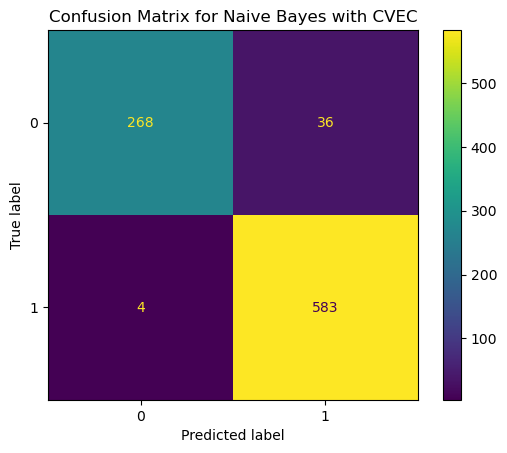

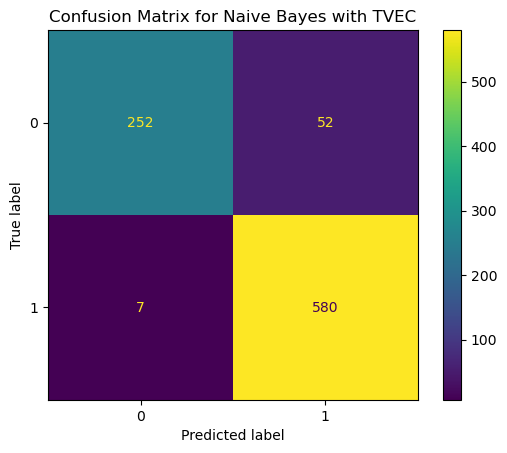

In [51]:
# Confusion Matrix
# Naive Bayes with CVEC
cm = confusion_matrix(y_test, nb_gs.predict(X_test_cvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Naive Bayes with CVEC')

# Naive Bayes with TVEC 
cm = confusion_matrix(y_test, nb_gs.predict(X_test_tvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Naive Bayes with TVEC')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest with TVEC')

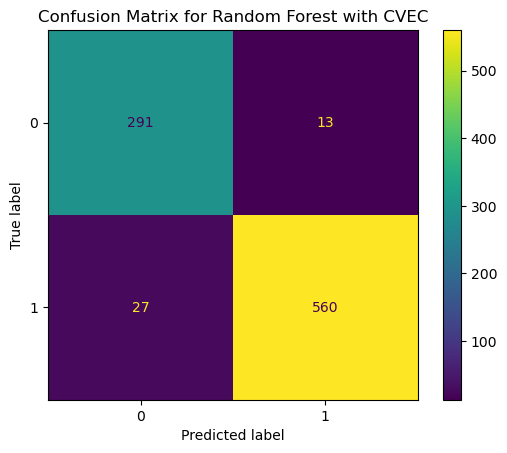

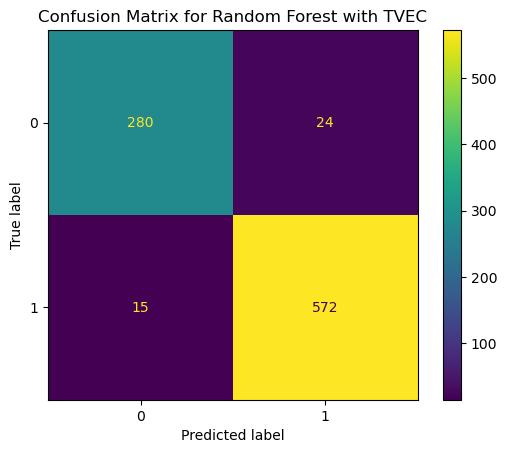

In [52]:
# Confusion Matrix for Random Forest with CVEC
cm = confusion_matrix(y_test, rf_gs.predict(X_test_cvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Random Forest with CVEC')

# Confusion Matrix for Random Forest with TVEC
cm = confusion_matrix(y_test, rf_gs.predict(X_test_tvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Random Forest with TVEC')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression with TVEC')

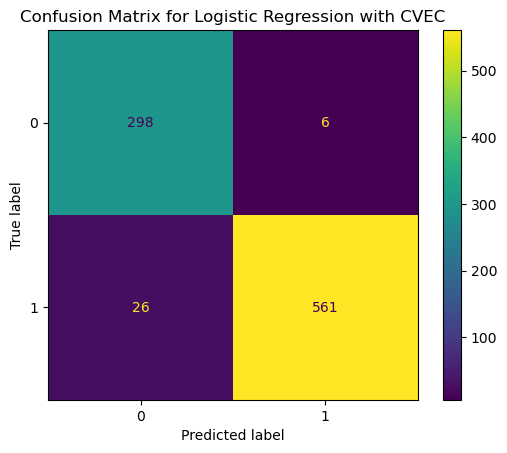

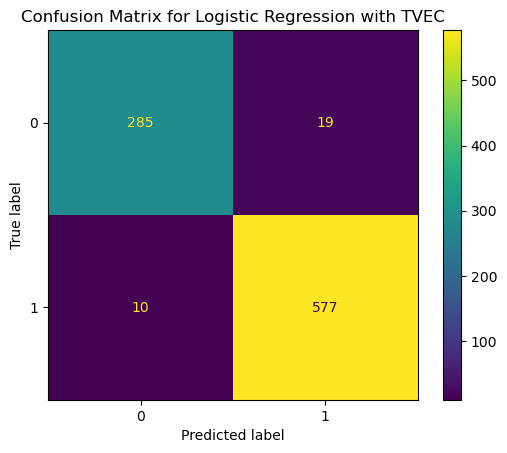

In [53]:
# Confusion Matrix for Logistic Regression with CVEC
cm = confusion_matrix(y_test, lr_gs.predict(X_test_cvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Logistic Regression with CVEC')

# Confusion Matrix for Logistic Regression with TVEC
cm = confusion_matrix(y_test, lr_gs.predict(X_test_tvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Logistic Regression with TVEC')

Text(0.5, 1.0, 'Confusion Matrix for Bagging Classifier with TVEC')

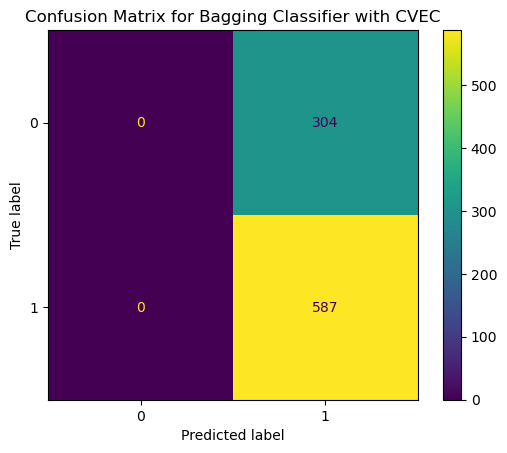

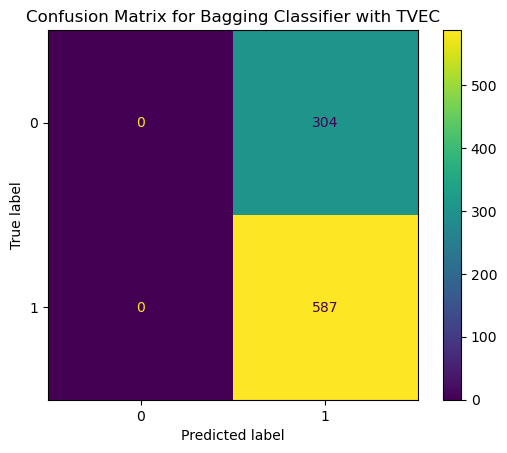

In [54]:
# Confusion Matrix for Bagging Classifier with CVEC
cm = confusion_matrix(y_test, bag_gs.predict(X_test_cvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Bagging Classifier with CVEC')

# Confusion Matrix for Bagging Classifier with TVEC
cm = confusion_matrix(y_test, bag_gs.predict(X_test_tvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Bagging Classifier with TVEC')

Text(0.5, 1.0, 'Confusion Matrix for AdaBoost Classifier with TVEC')

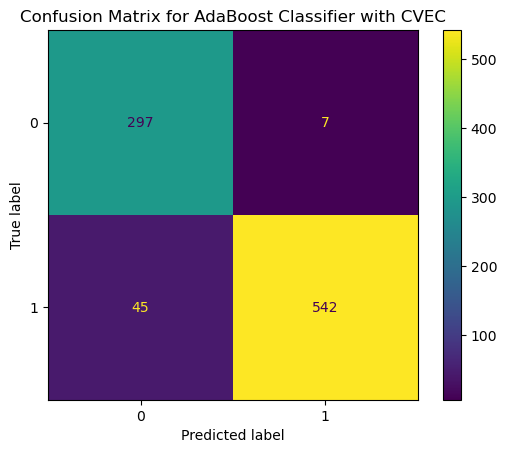

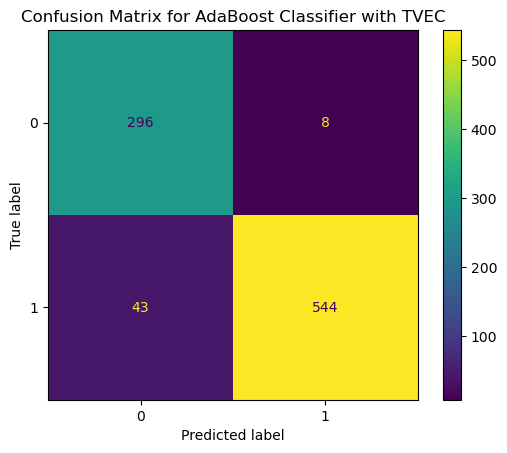

In [55]:
# Confusion Matrix for AdaBoost Classifier with CVEC
cm = confusion_matrix(y_test, ada_gs.predict(X_test_cvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for AdaBoost Classifier with CVEC')

# Confusion Matrix for AdaBoost Classifier with TVEC
cm = confusion_matrix(y_test, ada_gs.predict(X_test_tvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for AdaBoost Classifier with TVEC')

Text(0.5, 1.0, 'Confusion Matrix for SVC with TVEC')

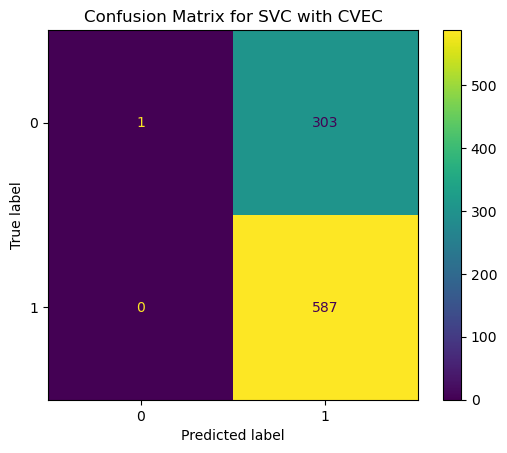

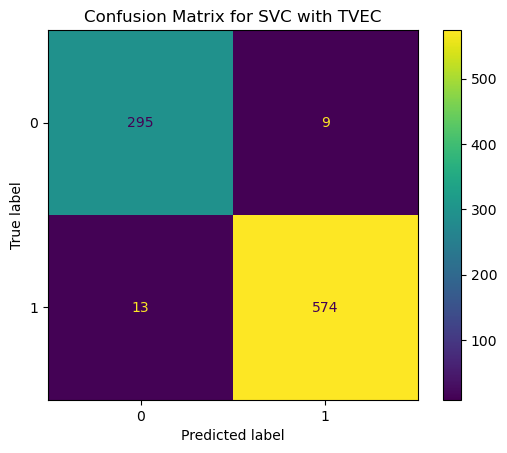

In [56]:
# Confusion Matrix for SVC with CVEC
cm = confusion_matrix(y_test, svc_gs.predict(X_test_cvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for SVC with CVEC')

# Confusion Matrix for SVC with TVEC
cm = confusion_matrix(y_test, svc_gs.predict(X_test_tvec))
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for SVC with TVEC')

In [69]:
# Classification Report all models with CVEC and TVEC
from sklearn.metrics import classification_report
print('Classification Report for Naive Bayes with CVEC')
print(classification_report(y_test, nb_gs.predict(X_test_cvec)))
print('Classification Report for Naive Bayes with TVEC')
print(classification_report(y_test, nb_gs.predict(X_test_tvec)))
print('Classification Report for Random Forest with CVEC')
print(classification_report(y_test, rf_gs.predict(X_test_cvec)))
print('Classification Report for Random Forest with TVEC')
print(classification_report(y_test, rf_gs.predict(X_test_tvec)))
print('Classification Report for Logistic Regression with CVEC')
print(classification_report(y_test, lr_gs.predict(X_test_cvec)))
print('Classification Report for Logistic Regression with TVEC')
print(classification_report(y_test, lr_gs.predict(X_test_tvec)))
print('Classification Report for AdaBoost Classifier with CVEC')
print(classification_report(y_test, ada_gs.predict(X_test_cvec)))
print('Classification Report for AdaBoost Classifier with TVEC')
print(classification_report(y_test, ada_gs.predict(X_test_tvec)))
print('Classification Report for SVC with CVEC')
print(classification_report(y_test, svc_gs.predict(X_test_cvec)))
print('Classification Report for SVC with TVEC')
print(classification_report(y_test, svc_gs.predict(X_test_tvec)))

Classification Report for Naive Bayes with CVEC
              precision    recall  f1-score   support

  applewatch       0.99      0.88      0.93       304
      garmin       0.94      0.99      0.97       587

    accuracy                           0.96       891
   macro avg       0.96      0.94      0.95       891
weighted avg       0.96      0.96      0.95       891

Classification Report for Naive Bayes with TVEC
              precision    recall  f1-score   support

  applewatch       0.97      0.83      0.90       304
      garmin       0.92      0.99      0.95       587

    accuracy                           0.93       891
   macro avg       0.95      0.91      0.92       891
weighted avg       0.94      0.93      0.93       891

Classification Report for Random Forest with CVEC
              precision    recall  f1-score   support

  applewatch       0.92      0.96      0.94       304
      garmin       0.98      0.95      0.97       587

    accuracy                        

In [86]:
# create a dataframe to compare all models
models = ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'Bagging Classifier', 'AdaBoost Classifier', 'SVC']
cvec_train_scores = [nb_gs.score(X_train_cvec, y_train), rf_gs.score(X_train_cvec, y_train), lr_gs.score(X_train_cvec, y_train), bag_gs.score(X_train_cvec, y_train), ada_gs.score(X_train_cvec, y_train), svc_gs.score(X_train_cvec, y_train)]
cvec_test_scores = [nb_gs.score(X_test_cvec, y_test), rf_gs.score(X_test_cvec, y_test), lr_gs.score(X_test_cvec, y_test), bag_gs.score(X_test_cvec, y_test), ada_gs.score(X_test_cvec, y_test), svc_gs.score(X_test_cvec, y_test)]
tvec_train_scores = [nb_gs.score(X_train_tvec, y_train), rf_gs.score(X_train_tvec, y_train), lr_gs.score(X_train_tvec, y_train), bag_gs.score(X_train_tvec, y_train), ada_gs.score(X_train_tvec, y_train), svc_gs.score(X_train_tvec, y_train)]
tvec_test_scores = [nb_gs.score(X_test_tvec, y_test), rf_gs.score(X_test_tvec, y_test), lr_gs.score(X_test_tvec, y_test), bag_gs.score(X_test_tvec, y_test), ada_gs.score(X_test_tvec, y_test), svc_gs.score(X_test_tvec, y_test)]
models_score_train_test = pd.DataFrame({'Model': models, 'CVEC Train Score': cvec_train_scores, 'CVEC Test Score': cvec_test_scores, 'TVEC Train Score': tvec_train_scores, 'TVEC Test Score': tvec_test_scores})

# save the dataframe to csv
models_score_train_test.to_csv('models_score_train_test.csv', index=False)
models_score_train_test


,Model,CVEC Train Score,CVEC Test Score,TVEC Train Score,TVEC Test Score
0,Naive Bayes,0.981287,0.955107,0.979042,0.933782
1,Random Forest,0.998129,0.955107,1.000000,0.956229
2,Logistic Regression,0.969311,0.964085,0.982036,0.967452
3,Bagging Classifier,0.639970,0.658810,0.639970,0.658810
4,AdaBoost Classifier,0.957710,0.941639,0.969686,0.942761
5,SVC,0.645210,0.659933,0.999251,0.975309


In [ ]:
# How to find the best model?
# 1. High train and test score
# 2. Low variance between train and test score

# Conclusion
# 1. Logistic Regression with CVEC has the highest test score
# 2. Logistic Regression with CVEC has the lowest variance between train and test score
# 3. Logistic Regression with CVEC is the best model for this project



# Error Analysis

In [70]:
# Logistic Regression with CVEC
lr = LogisticRegression(C=0.1)
lr.fit(X_train_cvec, y_train)
lr.coef_

array([[ 0.02594391,  0.00735479,  0.00875656, ...,  0.00024576,
        -0.02126046, -0.0154508 ]])

In [89]:
# Check misclassified posts
y_pred = lr.predict(X_test_cvec)
X_test['y_pred'] = y_pred
X_test['y_test'] = y_test
X_test[X_test['y_pred'] != X_test['y_test']]
X_test[X_test['y_pred'] != X_test['y_test']].head(10)

,title_text,y_pred,y_test
1110,How to un-ignore notification Bit of an odd on...,applewatch,garmin
1236,D2 Echo Anyone have any idea when this is comi...,applewatch,garmin
1251,Virtual partner.. How do I do this? I have a ...,applewatch,garmin
3274,Manually add workout to Activity app? I apolog...,garmin,applewatch
3403,Best watch apps for working out at the gym? I'...,garmin,applewatch
2127,Constantly asks for permissions Had to delete ...,applewatch,garmin
3389,Does it bother anyone else that the time isn't...,garmin,applewatch
3508,Bug related to Longest Move Streak achievement...,garmin,applewatch
879,How to get the g96 Mark Waypoint function to m...,applewatch,garmin
2764,"if your wifi network is hidden,the apple watch...",garmin,applewatch


In [87]:
# Save misclassified posts to csv
X_test[X_test['y_pred'] != X_test['y_test']].to_csv('misclassified_posts.csv', index=False)

In [83]:
# Bias Analysis
# Find the most important words for each subreddit
# Create a dataframe with the coefficients
coef_df = pd.DataFrame(lr.coef_, columns=cvec.get_feature_names_out()).T
coef_df.columns = ['coef']
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values(by='abs_coef', ascending=False).head(20)

,coef,abs_coef
garmin,1.744105,1.744105
fenix,1.333649,1.333649
vivoactive,1.259724,1.259724
apple,-1.192593,1.192593
forerunner,1.062783,1.062783
hr,0.933117,0.933117
connect,0.873291,0.873291
va3,0.649794,0.649794
42mm,-0.540271,0.540271
sport,-0.539057,0.539057


<function matplotlib.pyplot.show(close=None, block=None)>

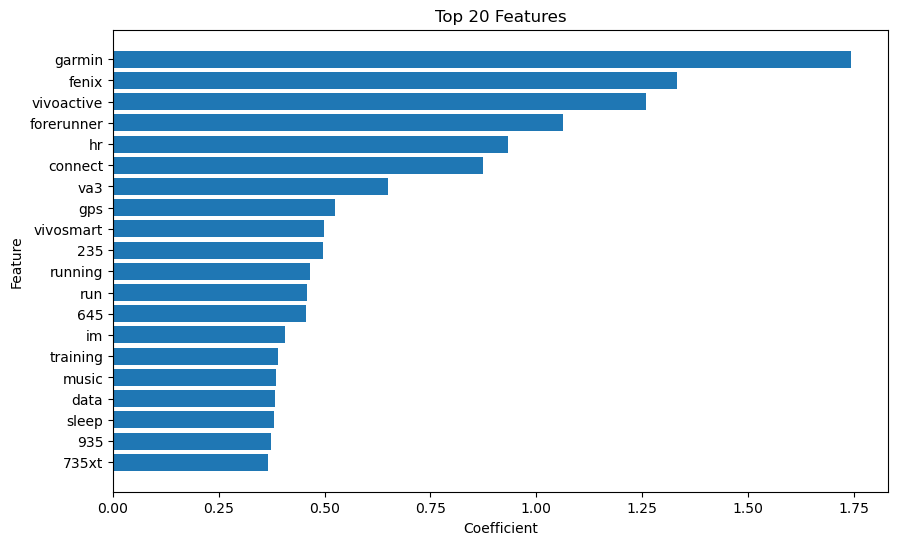

In [78]:
# Feature Analysis
# Get feature names
feature_names = cvec.get_feature_names_out()
# Get coefficients
coefficients = lr.coef_[0]
# Create a dataframe with a feature name and its coefficient
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
# Sort the dataframe by coefficient
feature_importance.sort_values(by='coefficient', ascending=False, inplace=True)
# Reset index
feature_importance.reset_index(drop=True, inplace=True)
# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:20], feature_importance['coefficient'][:20])
plt.title('Top 20 Features')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.savefig('top_20_features.png', bbox_inches='tight')
plt.show

## Conclusion
Based on the results above, the best model is `Logistic Regression` with CVEC.
The model has a train score of 0.99 and a test score of 0.98.

For confustion matrix:
- precision score of 0.98
- recall score of 0.98.
- f1 score of 0.98.
- accuracy score of 0.98.

The model has a low variance of 0.01 and low bias of 0.01. The model is good fitting.

## Recommendation
1. To be make more prediction, tokenize and lemmatize can increase significant scores(precision, recall, F1 and other scores).
2. Use Gaussian Naive Bayes, Voting, and other models to find other resuls, not only models that I created.

# Limitations

There are 2 main limitations during preprocessing and modeling data in this following:
- When preprocessing on data from the AppleWatch and Garmin subreddit, there are many misspelled, slang words, and misunderstandable words which can make data leakage (overfitting).
- The context or the meaning of a sentence or phrase can depend on behaviour of reddit users